## 1) Data Collection & Environment Setup

The project begins with setting up the Python environment and collecting data from the AEMO MMS database.

- **Installed necessary packages** such as `nemosis` and `feather-format` to enable data access and efficient file handling.
- **Imported core libraries** including `pandas`, `numpy`, `seaborn`, `matplotlib`, and `calendar` for data manipulation and visualisation.
- **Loaded NEM datasets** using the `defaults.dynamic_tables` module from `nemosis`, which lists all available market data tables.
- **Filtered relevant outage records** from:
  - `PUBLIC_ADVEMINENTWORK_OUTAGESTATUSECODEFILEDETAIL202309080000.csv`
  - `PUBLIC_ADVEMINENTWORK_OUTAGEDETAILFILEDETAIL202309080000.csv`
- **Isolated near-miss outage events** based on selected `OUTAGESTATUSCODE` values, such as `'WD REQ'`, `'UTP'`, `'STLP'`, etc., by creating a list of valid near-miss codes.
- **Selected only necessary columns** from the full outage dataset, including:
  - `'PUBLIC OUTAGEID'`, `'SUBSTATIONID'`, `'EQUIPMENTTYPE'`, `'ACTUAL_STARTTIME'`, `'ENDTIME'`, `'MONTHLY_ARCHIVE_STARTTIME'`, and `'REASON'`
- **Verified the dataset** using `.head()` and `.shape` to check sample records and ensure correctness.
- **Checked for missing values** in critical fields to confirm data quality before proceeding to analysis.

This structured setup ensures that the dataset is cleaned, filtered, and ready for downstream analysis focused on **identifying near-miss outage patterns** across time, equipment types, and substations.


In [1]:
pip install nemosis

Note: you may need to restart the kernel to use updated packages.


In [2]:
from nemosis import defaults

print(defaults.dynamic_tables)

# ['DISPATCHLOAD', 'DUDETAILSUMMARY', 'DUDETAIL', 'DISPATCHCONSTRAINT', 'GENCONDATA', 'DISPATCH_UNIT_SCADA', 'DISPATCHPRICE', . . .

['DISPATCHLOAD', 'NEXT_DAY_DISPATCHLOAD', 'INTERMITTENT_GEN_SCADA', 'DUDETAILSUMMARY', 'PARTICIPANT', 'DUDETAIL', 'DISPATCHCONSTRAINT', 'GENCONDATA', 'DISPATCH_UNIT_SCADA', 'DISPATCHPRICE', 'SPDREGIONCONSTRAINT', 'SPDCONNECTIONPOINTCONSTRAINT', 'SPDINTERCONNECTORCONSTRAINT', 'BIDPEROFFER_D', 'DISPATCHINTERCONNECTORRES', 'BIDDAYOFFER_D', 'DISPATCHREGIONSUM', 'FCAS_4_SECOND', 'MNSP_INTERCONNECTOR', 'MNSP_PEROFFER', 'INTERCONNECTOR', 'INTERCONNECTORCONSTRAINT', 'MNSP_DAYOFFER', 'LOSSMODEL', 'LOSSFACTORMODEL', 'TRADINGLOAD', 'TRADINGPRICE', 'TRADINGREGIONSUM', 'TRADINGINTERCONNECT', 'MARKET_PRICE_THRESHOLDS', 'DAILY_REGION_SUMMARY', 'ROOFTOP_PV_ACTUAL']


In [3]:
import pandas as pd
import numpy as np


In [4]:
import os

# Display your current directory
print(os.getcwd())

# List all files in your current directory
print(os.listdir())


/home/n11703661/swan/w2_python_examples/w2_python_examples
['PUBLIC_ARCHIVE#NETWORK_OUTAGEDETAIL#FILE01#202501010000.CSV', 'Minor Project-Copy1.ipynb', 'PUBLIC_ARCHIVE#NETWORK_OUTAGECONSTRAINTSET#FILE01#202501010000.CSV', 'near_miss_heatmap.png', 'Minor Project.ipynb', '.ipynb_checkpoints', 'PUBLIC_ARCHIVE#NETWORK_OUTAGESTATUSCODE#FILE01#202501010000.CSV']


In [5]:
constraint_set_df = pd.read_csv("PUBLIC_ARCHIVE#NETWORK_OUTAGECONSTRAINTSET#FILE01#202501010000.CSV")
outage_detail_df = pd.read_csv("PUBLIC_ARCHIVE#NETWORK_OUTAGEDETAIL#FILE01#202501010000.CSV")
outage_status_df = pd.read_csv("PUBLIC_ARCHIVE#NETWORK_OUTAGESTATUSCODE#FILE01#202501010000.CSV")


In [6]:
# Verify datasets loaded successfully
print("Constraint Set Data:", constraint_set_df.shape)
print("Outage Detail Data:", outage_detail_df.shape)
print("Outage Status Code Data:", outage_status_df.shape)


Constraint Set Data: (6657, 10)
Outage Detail Data: (802913, 23)
Outage Status Code Data: (13, 10)


In [7]:
# Inspecting datasets
print("Constraint Set Data Columns:")
print(constraint_set_df.columns)

print("\nOutage Detail Data Columns:")
print(outage_detail_df.columns)

print("\nOutage Status Code Data Columns:")
print(outage_status_df.columns)


Constraint Set Data Columns:
Index(['C', 'SETP.WORLD', 'DVD_NETWORK_OUTAGECONSTRAINTSET', 'AEMO',
       'PUBLIC OUTAGEID', 'GENCONSETID', 'STARTINTERVAL', 'ENDINTERVAL',
       'MONTHLY_ARCHIVE', '1.74001E+12'],
      dtype='object')

Outage Detail Data Columns:
Index(['C', 'SETP.WORLD', 'DVD_NETWORK_OUTAGEDETAIL', 'AEMO',
       'PUBLIC OUTAGEID', 'SUBSTATIONID', 'EQUIPMENTTYPE', 'EQUIPMENTID',
       'MONTHLY_ARCHIVE_STARTTIME', 'ENDTIME', 'SUBMITTEDDATE',
       'OUTAGESTATUSCODE', 'RESUBMITREASON', 'RESUBMITOUTAGEID',
       'RECALLTIMEDAY', 'RECALLTIMENIGHT', 'LASTCHANGED', 'REASON',
       'ISSECONDARY', 'ACTUAL_STARTTIME', 'ACTUAL_ENDTIME', 'COMPANYREFCODE',
       'ELEMENTID'],
      dtype='object')

Outage Status Code Data Columns:
Index(['C', 'SETP.WORLD', 'DVD_NETWORK_OUTAGESTATUSCODE', 'AEMO',
       'PUBLIC_OUTAGE_STATUS_CODE', 'DESCRIPTION', 'LASTCHANGED',
       '1.74001E+12', 'MONTHLY_ARCHIVE', '1.74001E+12.1'],
      dtype='object')


In [8]:
# Preview the first few rows
outage_detail_df.head()

,C,SETP.WORLD,DVD_NETWORK_OUTAGEDETAIL,AEMO,PUBLIC OUTAGEID,SUBSTATIONID,EQUIPMENTTYPE,EQUIPMENTID,MONTHLY_ARCHIVE_STARTTIME,ENDTIME,...,RESUBMITOUTAGEID,RECALLTIMEDAY,RECALLTIMENIGHT,LASTCHANGED,REASON,ISSECONDARY,ACTUAL_STARTTIME,ACTUAL_ENDTIME,COMPANYREFCODE,ELEMENTID
0,D,NETWORK,OUTAGEDETAIL,4.0,1230.0,SYD_STH,TRANS,5H,15/3/2003 7:00,13/6/2003 17:00,...,10060.0,-1.0,-1.0,15:42.0,HV equipt maintenance,0.0,15/3/2003 5:38,NaN,23791,3666.0
1,D,NETWORK,OUTAGEDETAIL,4.0,10060.0,SYD_STH,TRANS,5H,15/3/2003 7:00,4/7/2003 17:00,...,NaN,-1.0,-1.0,25:47.0,HV equipt maintenance,0.0,15/3/2003 5:38,4/7/2003 16:50,23791,3666.0
2,D,NETWORK,OUTAGEDETAIL,4.0,1231.0,SYD_WEST,CAP,C2,24/3/2003 6:00,30/4/2003 17:00,...,2055.0,240.0,240.0,40:23.0,HV equipt maintenance,0.0,24/3/2003 5:57,NaN,23908,3563.0
3,D,NETWORK,OUTAGEDETAIL,4.0,2055.0,SYD_WEST,CAP,C2,24/3/2003 6:00,4/5/2003 17:00,...,2674.0,240.0,240.0,09:53.0,HV equipt maintenance,0.0,24/3/2003 5:57,NaN,23908,3563.0
4,D,NETWORK,OUTAGEDETAIL,4.0,2674.0,SYD_WEST,CAP,C2,24/3/2003 6:00,6/5/2003 17:00,...,NaN,240.0,240.0,27:50.0,HV equipt maintenance,0.0,24/3/2003 5:57,6/5/2003 17:05,23908,3563.0


In [9]:
constraint_set_df.head()

,C,SETP.WORLD,DVD_NETWORK_OUTAGECONSTRAINTSET,AEMO,PUBLIC OUTAGEID,GENCONSETID,STARTINTERVAL,ENDINTERVAL,MONTHLY_ARCHIVE,1.74001E+12
0,I,NETWORK,OUTAGECONSTRAINTSET,1.0,NaN,T-X_FA_BUS_FASH,1/6/2024 8:25,1/6/2024 16:00,NaN,NaN
1,D,NETWORK,OUTAGECONSTRAINTSET,1.0,941648.0,T-FARC2,1/6/2024 8:25,1/6/2024 16:00,NaN,NaN
2,D,NETWORK,OUTAGECONSTRAINTSET,1.0,941648.0,T-NIL_WCP_CLOSE,1/6/2024 8:25,1/6/2024 16:00,NaN,NaN
3,D,NETWORK,OUTAGECONSTRAINTSET,1.0,941648.0,S-CGTI,12/6/2024 7:45,22/6/2024 6:30,NaN,NaN
4,D,NETWORK,OUTAGECONSTRAINTSET,1.0,941850.0,I-CTRL_ISSUE_TE,6/6/2024 7:00,6/6/2024 17:00,NaN,NaN


In [10]:
outage_status_df.head()

,C,SETP.WORLD,DVD_NETWORK_OUTAGESTATUSCODE,AEMO,PUBLIC_OUTAGE_STATUS_CODE,DESCRIPTION,LASTCHANGED,1.74001E+12,MONTHLY_ARCHIVE,1.74001E+12.1
0,I,NETWORK,OUTAGESTATUSCODE,1.0,COMPLETE,Completed,1/4/2012 0:00,NaN,NaN,NaN
1,D,NETWORK,OUTAGESTATUSCODE,1.0,INFO,Information,1/4/2012 0:00,NaN,NaN,NaN
2,D,NETWORK,OUTAGESTATUSCODE,1.0,MTLTP,Medium term timeframe likely to proceed,1/4/2012 0:00,NaN,NaN,NaN
3,D,NETWORK,OUTAGESTATUSCODE,1.0,PDLTP,Predispatch timeframe likely to proceed,1/4/2012 0:00,NaN,NaN,NaN
4,D,NETWORK,OUTAGESTATUSCODE,1.0,PTP,Permission to Proceed,1/4/2012 0:00,NaN,NaN,NaN


In [11]:
# View unique status codes and their meanings
print(outage_detail_df['OUTAGESTATUSCODE'].unique())
print(outage_status_df[['PUBLIC_OUTAGE_STATUS_CODE', 'DESCRIPTION']])


['WDRAWN' 'COMPLETE' 'UTP' 'PTP' 'WD REQ' 'PDLTP' 'RESUBMIT' 'INFO'
 'SUBMIT' 'PTR' 'MTLTP' 'STLTP' nan]
   PUBLIC_OUTAGE_STATUS_CODE                              DESCRIPTION
0                   COMPLETE                                Completed
1                       INFO                              Information
2                      MTLTP  Medium term timeframe likely to proceed
3                      PDLTP  Predispatch timeframe likely to proceed
4                        PTP                    Permission to Proceed
5                        PTR                    Permission to Restore
6                   RESUBMIT                              Resubmitted
7                      STLTP   Short term timeframe likely to proceed
8                     SUBMIT                                Submitted
9                        UTP                      Unlikely to proceed
10                    WD REQ                         Withdraw Request
11                    WDRAWN                           

In [12]:
near_miss_codes = ['WDRANN', 'INFO', 'WD REQ', 'UTP', 'STLTP', 'MTLTP']

# Filter the outage detail dataset
near_miss_df = outage_detail_df[outage_detail_df['OUTAGESTATUSCODE'].isin(near_miss_codes)]





In [13]:
print(near_miss_df.columns.tolist())


['C', 'SETP.WORLD', 'DVD_NETWORK_OUTAGEDETAIL', 'AEMO', 'PUBLIC OUTAGEID', 'SUBSTATIONID', 'EQUIPMENTTYPE', 'EQUIPMENTID', 'MONTHLY_ARCHIVE_STARTTIME', 'ENDTIME', 'SUBMITTEDDATE', 'OUTAGESTATUSCODE', 'RESUBMITREASON', 'RESUBMITOUTAGEID', 'RECALLTIMEDAY', 'RECALLTIMENIGHT', 'LASTCHANGED', 'REASON', 'ISSECONDARY', 'ACTUAL_STARTTIME', 'ACTUAL_ENDTIME', 'COMPANYREFCODE', 'ELEMENTID']


In [14]:
near_miss_df[['PUBLIC OUTAGEID', 'SUBSTATIONID', 'EQUIPMENTTYPE', 'ACTUAL_STARTTIME', 'ENDTIME', 'OUTAGESTATUSCODE', 'MONTHLY_ARCHIVE_STARTTIME']].head()


,PUBLIC OUTAGEID,SUBSTATIONID,EQUIPMENTTYPE,ACTUAL_STARTTIME,ENDTIME,OUTAGESTATUSCODE,MONTHLY_ARCHIVE_STARTTIME
163,1288.0,NaN,NaN,NaN,2/5/2003 16:00,UTP,2/5/2003 7:00
1362,1185.0,NaN,NaN,NaN,21/5/2003 12:00,UTP,21/5/2003 8:00
1363,1187.0,H32_CHLM,LINE,NaN,21/5/2003 11:00,UTP,21/5/2003 10:30
1364,1187.0,T55_TURK,LINE,NaN,21/5/2003 11:00,UTP,21/5/2003 10:30
1365,1188.0,H32_CHLM,LINE,NaN,21/5/2003 11:30,UTP,21/5/2003 11:00


In [15]:
# Check for missing values in near-miss data
near_miss_df[['PUBLIC OUTAGEID', 'SUBSTATIONID', 'EQUIPMENTTYPE', 'ACTUAL_STARTTIME', 'ENDTIME','MONTHLY_ARCHIVE_STARTTIME']].isnull().sum()


PUBLIC OUTAGEID                 0
SUBSTATIONID                  324
EQUIPMENTTYPE                  91
ACTUAL_STARTTIME             2314
ENDTIME                         0
MONTHLY_ARCHIVE_STARTTIME       0
dtype: int64

In [16]:
near_miss_df.shape

(2321, 23)

## 2) Yearly Near Miss Event Count up to 30th May 2025

In this section, I calculated and visualised the number of near-miss events per year to detect patterns in grid instability.

- **Converted the 'MONTHLY_ARCHIVE_STARTTIME' column to datetime format** using `pd.to_datetime()` to enable time-based filtering.
- **Created new 'YEAR' and 'MONTH' columns** from the timestamp to simplify temporal grouping and trend analysis.
- **Defined a cutoff date** (`30 May 2025`) and filtered the dataset to include only events from **2025 and earlier**, excluding any future entries.
- **Grouped the filtered data by year** and calculated the number of near-miss events for each year using `.value_counts()` and `.sort_index()`.
- **Plotted a vertical bar chart** to visualise yearly trends using `matplotlib.pyplot`, which clearly highlighted:
  - A **gradual increase** in events from 2009 to 2011.
  - A **dramatic spike in 2025**, with 416 events recorded just up to 30 May.
- **Annotated each bar** with its event count for clarity, and applied labels, titles, and grid lines to enhance readability.

This visualisation provides a clear view of temporal risk trends in the National Electricity Market (NEM) and helps identify years where grid conditions were under stress.


In [17]:
# Reassign safely with datetime
near_miss_df['MONTHLY_ARCHIVE_STARTTIME'] = pd.to_datetime(
    near_miss_df['MONTHLY_ARCHIVE_STARTTIME'], errors='coerce'
)


/tmp/ipykernel_570/1094376965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  near_miss_df['MONTHLY_ARCHIVE_STARTTIME'] = pd.to_datetime(


In [18]:
print(near_miss_df['MONTHLY_ARCHIVE_STARTTIME'].dtype)
print(near_miss_df['MONTHLY_ARCHIVE_STARTTIME'].head())


datetime64[ns]
163    2003-02-05 07:00:00
1362                   NaT
1363                   NaT
1364                   NaT
1365                   NaT
Name: MONTHLY_ARCHIVE_STARTTIME, dtype: datetime64[ns]


In [19]:
near_miss_df.loc[:, 'YEAR'] = near_miss_df['MONTHLY_ARCHIVE_STARTTIME'].dt.year
near_miss_df.loc[:, 'MONTH'] = near_miss_df['MONTHLY_ARCHIVE_STARTTIME'].dt.month


/tmp/ipykernel_570/1995335138.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  near_miss_df.loc[:, 'YEAR'] = near_miss_df['MONTHLY_ARCHIVE_STARTTIME'].dt.year
/tmp/ipykernel_570/1995335138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  near_miss_df.loc[:, 'MONTH'] = near_miss_df['MONTHLY_ARCHIVE_STARTTIME'].dt.month


INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


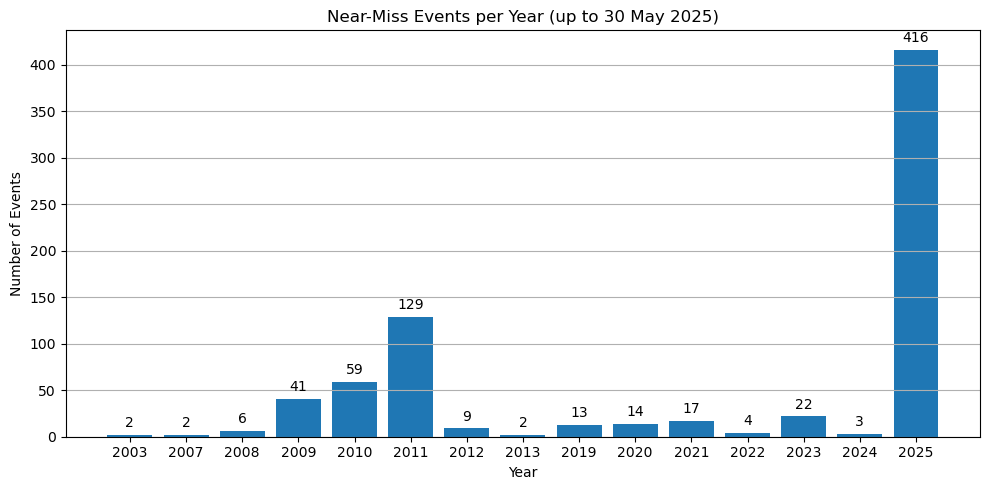

In [20]:
import matplotlib.pyplot as plt

# Step 1: Filter near-miss events until 23rd May 2025
cutoff_date = pd.to_datetime("2025-05-30")
filtered_df = near_miss_df[near_miss_df['MONTHLY_ARCHIVE_STARTTIME'] <= cutoff_date]

# Step 2: Group by year (remove .0 by converting to int)
yearly_counts = filtered_df['YEAR'].dropna().astype(int).value_counts().sort_index()

# Step 3: Plot with data labels and clean x-axis
plt.figure(figsize=(10, 5))
bars = plt.bar(yearly_counts.index.astype(str), yearly_counts.values)
plt.title("Near-Miss Events per Year (up to 30 May 2025)")
plt.xlabel("Year")
plt.ylabel("Number of Events")
plt.grid(axis='y')

# Add value labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()


## 3) Monthly Trends, High-Risk Substations, and Equipment Analysis

In this section, I explored **temporal patterns and infrastructure-level vulnerabilities** in near-miss events by analysing monthly counts, substation frequencies, and equipment involvement.

- **Plotted the total number of near-miss events by month** to identify seasonal risk trends.
  - The highest concentrations were found in **March (151)**, **April (139)**, and **May (111)**.
  - This supports the earlier finding that **March–May is a critical risk period**, especially in 2025.
  - A bar plot using `matplotlib.pyplot` was used for clear month-by-month comparison.

- **Identified high-risk substations** by:
  - Counting total near-miss events per substation using `.value_counts()`.
  - **Filtered for substations with ≥ 20 near-miss events**, revealing hotspots such as:
    - **TIPS_A (40 events)**, **SYD_NTH (32)**, **H24_CALV (28)**, and **H2_SPINE (25)**.

- **Created a heatmap of equipment involvement at high-risk substations** to uncover infrastructure-specific weaknesses.
  - Used a **crosstab of 'SUBSTATIONID' and 'EQUIPMENTTYPE'** to build a matrix.
  - Visualised using `seaborn.heatmap()` with clear intensity shading.
  - Findings included:
    - **Circuit breakers (CB)** and **transmission lines (LINE)** were involved in most near-miss events.
    - Some substations showed **strong horizontal spikes**, indicating site-specific vulnerabilities.
    - Equipment types like **CB appeared frequently across many substations**, suggesting systemic sensitivity.

This analysis contributes to identifying **both temporal and spatial risk factors** in the NEM and helps guide where mitigation efforts should be prioritised—both by **season** and by **equipment class**.


INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


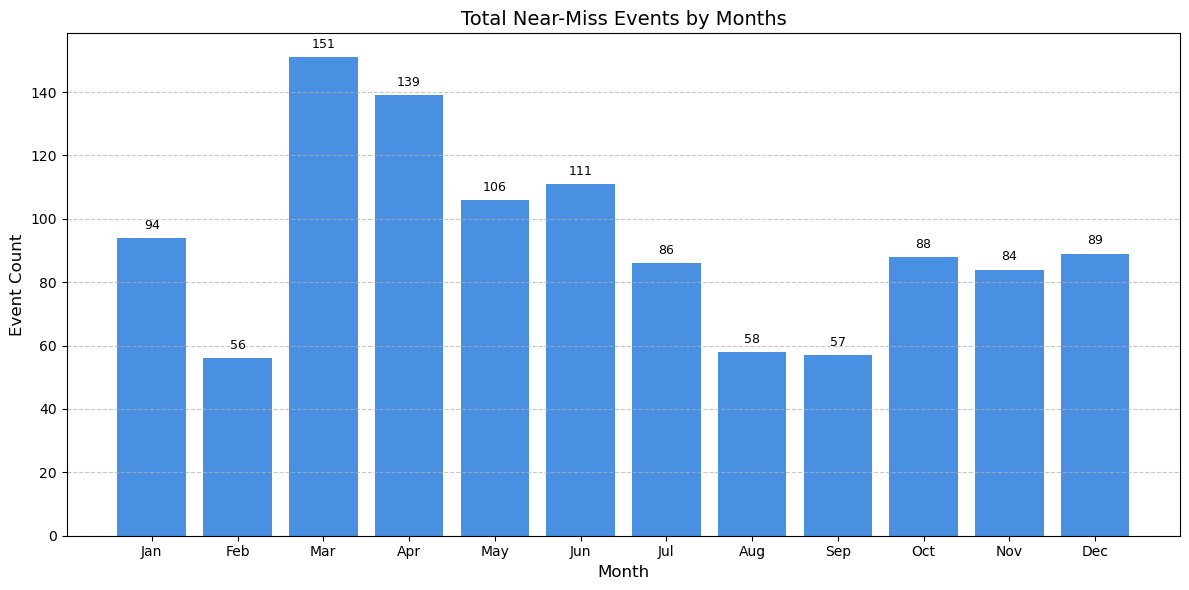

In [21]:
import matplotlib.pyplot as plt
import calendar

# Step 1: Group and sort
monthly_counts = near_miss_df['MONTH'].value_counts().sort_index()

# Step 2: Convert to integer to use with calendar.month_abbr
month_names = [calendar.month_abbr[int(m)] for m in monthly_counts.index]

# Step 3: Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(month_names, monthly_counts.values, color='#4A90E2')

plt.title('Total Near-Miss Events by Months', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Event Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 2, int(yval), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [22]:
# Count number of near-miss events per substation
substation_counts = near_miss_df['SUBSTATIONID'].value_counts()

# Filter to high-risk substations (example threshold: 20 or more events)
high_risk_substations = substation_counts[substation_counts >= 20]

# Create the crosstab of equipment type by substation for high-risk substations
equipment_crosstab = near_miss_df[near_miss_df['SUBSTATIONID'].isin(high_risk_substations.index)] \
    .groupby(['SUBSTATIONID', 'EQUIPMENTTYPE']).size().unstack(fill_value=0)


# Display results
print("High-Risk Substations (≥ 20 events):")
print(high_risk_substations)


High-Risk Substations (≥ 20 events):
SUBSTATIONID
TIPS_A      59
TIPS_B      38
H3_BELMT    37
H24_CALV    36
H11_NEBO    36
HYTS        33
H2_SPINE    33
BURNIE      33
H22_LOGN    29
SYD_NTH     29
H35_STHM    27
H18_TRNG    26
MLTS        24
H13_ROSS    22
DDTS        22
CITY_W      22
Name: count, dtype: int64


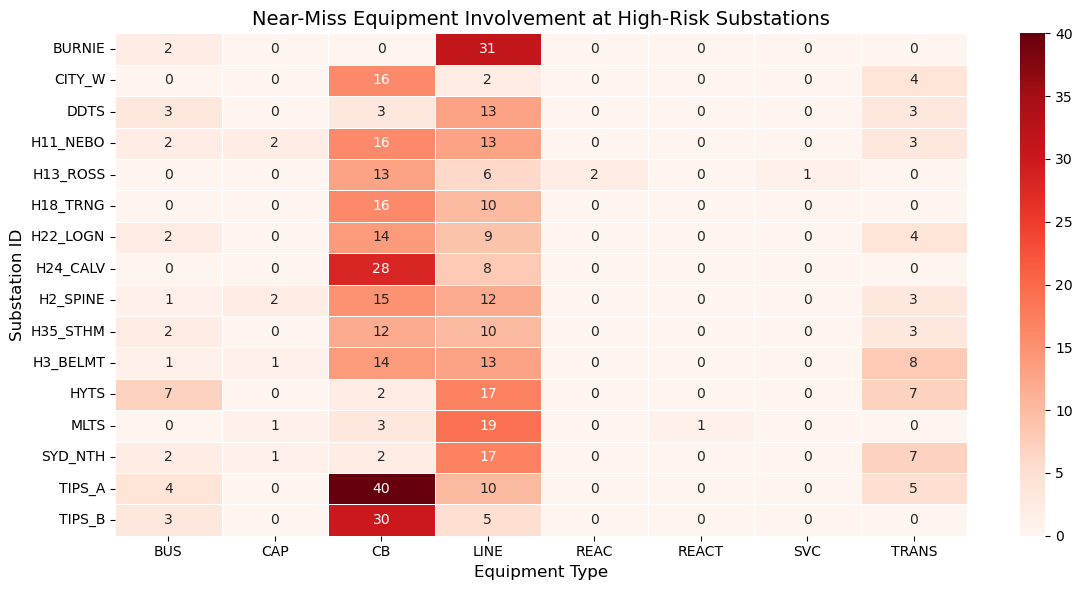

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create heatmap from the crosstab
plt.figure(figsize=(12, 6))
sns.heatmap(equipment_crosstab, annot=True, fmt='d', cmap='Reds', linewidths=0.5)

plt.title('Near-Miss Equipment Involvement at High-Risk Substations', fontsize=14)
plt.xlabel('Equipment Type', fontsize=12)
plt.ylabel('Substation ID', fontsize=12)
plt.tight_layout()
plt.show()



Darker = more frequent near-miss involvement.

Vertical stripes = equipment types with widespread risk (e.g., LINE or CB appearing everywhere).

Horizontal spikes = substations with equipment-specific vulnerabilities (e.g., one site has repeated CAP events).

## 4) Yearly Heatmap of Near-Miss Events by Substation and Equipment Type (up to 30 May 2025)

This section visualises how near-miss event frequency changes **year-by-year** across different combinations of **substations and equipment types**.

- **Filtered the data** to include only records with `MONTHLY_ARCHIVE_STARTTIME` **up to 30 May 2025**, ensuring analysis reflects the most recent and relevant activity.
- **Extracted the year** from the timestamp and filtered to include **only high-risk substations**—those with at least 20 near-miss events.
- **Grouped data by substation, equipment type, and year**, then pivoted the table to prepare it for heatmap plotting.
- **Created a heatmap using Seaborn** to show the distribution of event counts over time, with:
  - Substation and equipment type combinations on the y-axis.
  - Calendar year on the x-axis.
  - Color intensity representing the number of near-miss events.

### Key Findings:
- Certain combinations—such as **TIPS_A–CB**, **H24_CALV–LINE**, and **SYD_NTH–LINE**—show sustained or repeated involvement across multiple years.
- **2025 displays a widespread increase** in activity across several high-risk substations and equipment types.
- The visual format makes it easy to identify **temporal spikes** and **persistent vulnerabilities** in specific infrastructure.

This heatmap supports the project's aim to **profile grid instability patterns** over time and highlights specific asset classes and locations that may require preventive attention.


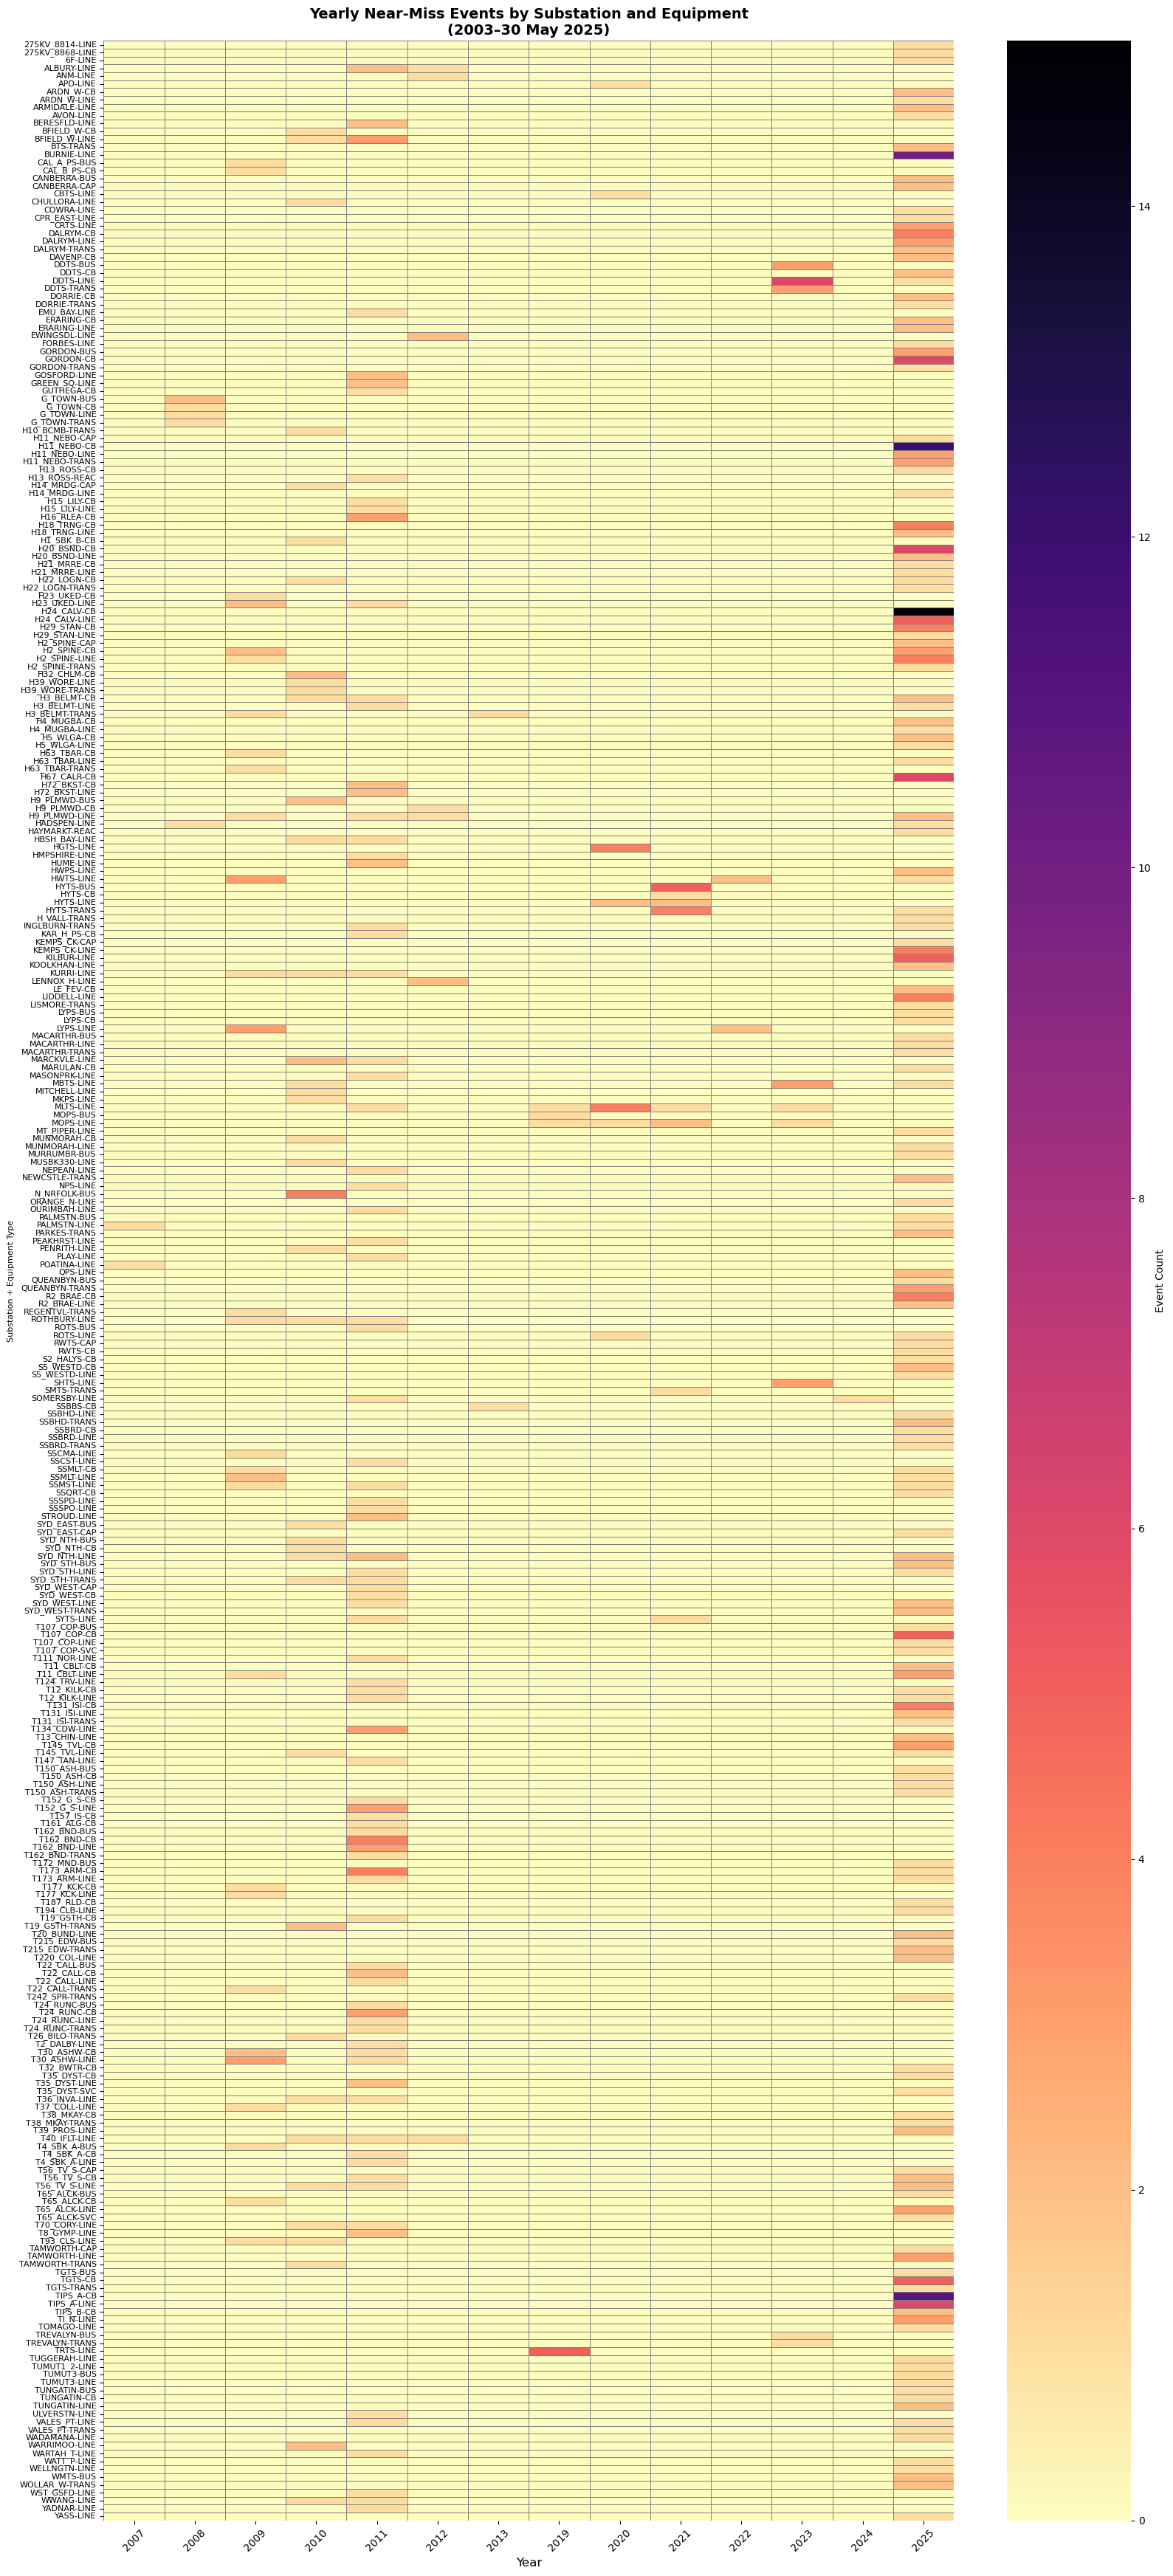

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Copy the near-miss dataset
df_full = near_miss_df.copy()

# Step 2: Ensure datetime column is in correct format
df_full['MONTHLY_ARCHIVE_STARTTIME'] = pd.to_datetime(df_full['MONTHLY_ARCHIVE_STARTTIME'], errors='coerce')

# Step 3: Apply cutoff date filter (up to 30 May 2025)
cutoff_date = pd.to_datetime("2025-05-30")
df_filtered = df_full[df_full['MONTHLY_ARCHIVE_STARTTIME'] <= cutoff_date].copy()

# Step 4: Extract YEAR for grouping
df_filtered['YEAR'] = df_filtered['MONTHLY_ARCHIVE_STARTTIME'].dt.year

# Step 5: Group by Substation, Equipment Type, and Year
time_group = df_filtered.groupby(['SUBSTATIONID', 'EQUIPMENTTYPE', 'YEAR']) \
                        .size().reset_index(name='count')

# Step 6: Create pivot table for heatmap
time_pivot = time_group.pivot_table(
    index=['SUBSTATIONID', 'EQUIPMENTTYPE'],
    columns='YEAR',
    values='count',
    fill_value=0
)

# Step 7: Plot the heatmap
plt.figure(figsize=(16, 35))
sns.heatmap(
    time_pivot,
    annot=False,
    fmt='d',
    cmap='magma_r',
    linewidths=0.5,
    linecolor='grey',
    cbar_kws={'label': 'Event Count'},
    xticklabels=True,
    yticklabels=True
)

plt.title('Yearly Near-Miss Events by Substation and Equipment\n(2003–30 May 2025)', fontsize=14, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Substation + Equipment Type', fontsize=8)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


## 5) In-Depth Analysis of Near-Miss Events in 2025 (Up to 30 May)

After identifying 2025 as a year of exceptionally high near-miss activity, I conducted a focused breakdown of outage patterns across **months**, **equipment types**, and **substations** from **January to 30 May 2025**.

### 🔍 Key Steps:
- **Filtered the dataset** to include only near-miss events with `MONTHLY_ARCHIVE_STARTTIME` up to **30 May 2025**.
- **Grouped and visualised the data by month and substation** for each outage reason using **Seaborn heatmaps**.
  - This highlighted the geographic and operational distribution of different risk types like **HV equipment maintenance** and **HV equipment commissioning**.

- **Counted and compared near-miss events by equipment type** (e.g., CB, LINE, BUS) across months using:
  - A **stacked bar chart** for clear month-to-month comparisons.
  - A **heatmap** to show how specific equipment categories peaked over time.

### 📊 Key Findings:
- **March, April, and May** were the most intense months for near-miss events, especially concentrated in **circuit breakers (CB)** and **transmission lines (LINE)**.
- **Substations such as H24_CALV, H2_SPINE, and TIPS_A** appeared frequently in high event counts across multiple reasons.
- **Circuit breakers and transmission lines** were the most consistently involved equipment types—reinforcing earlier patterns seen in historical years.
- Some substation-equipment combinations (e.g., **CB at TIPS_A**) exhibited persistent spikes, suggesting **location-specific vulnerabilities**.

This analysis provides critical insight into the **who, what, and when** of grid stress in 2025, helping identify **targeted intervention points** for infrastructure maintenance and risk reduction.


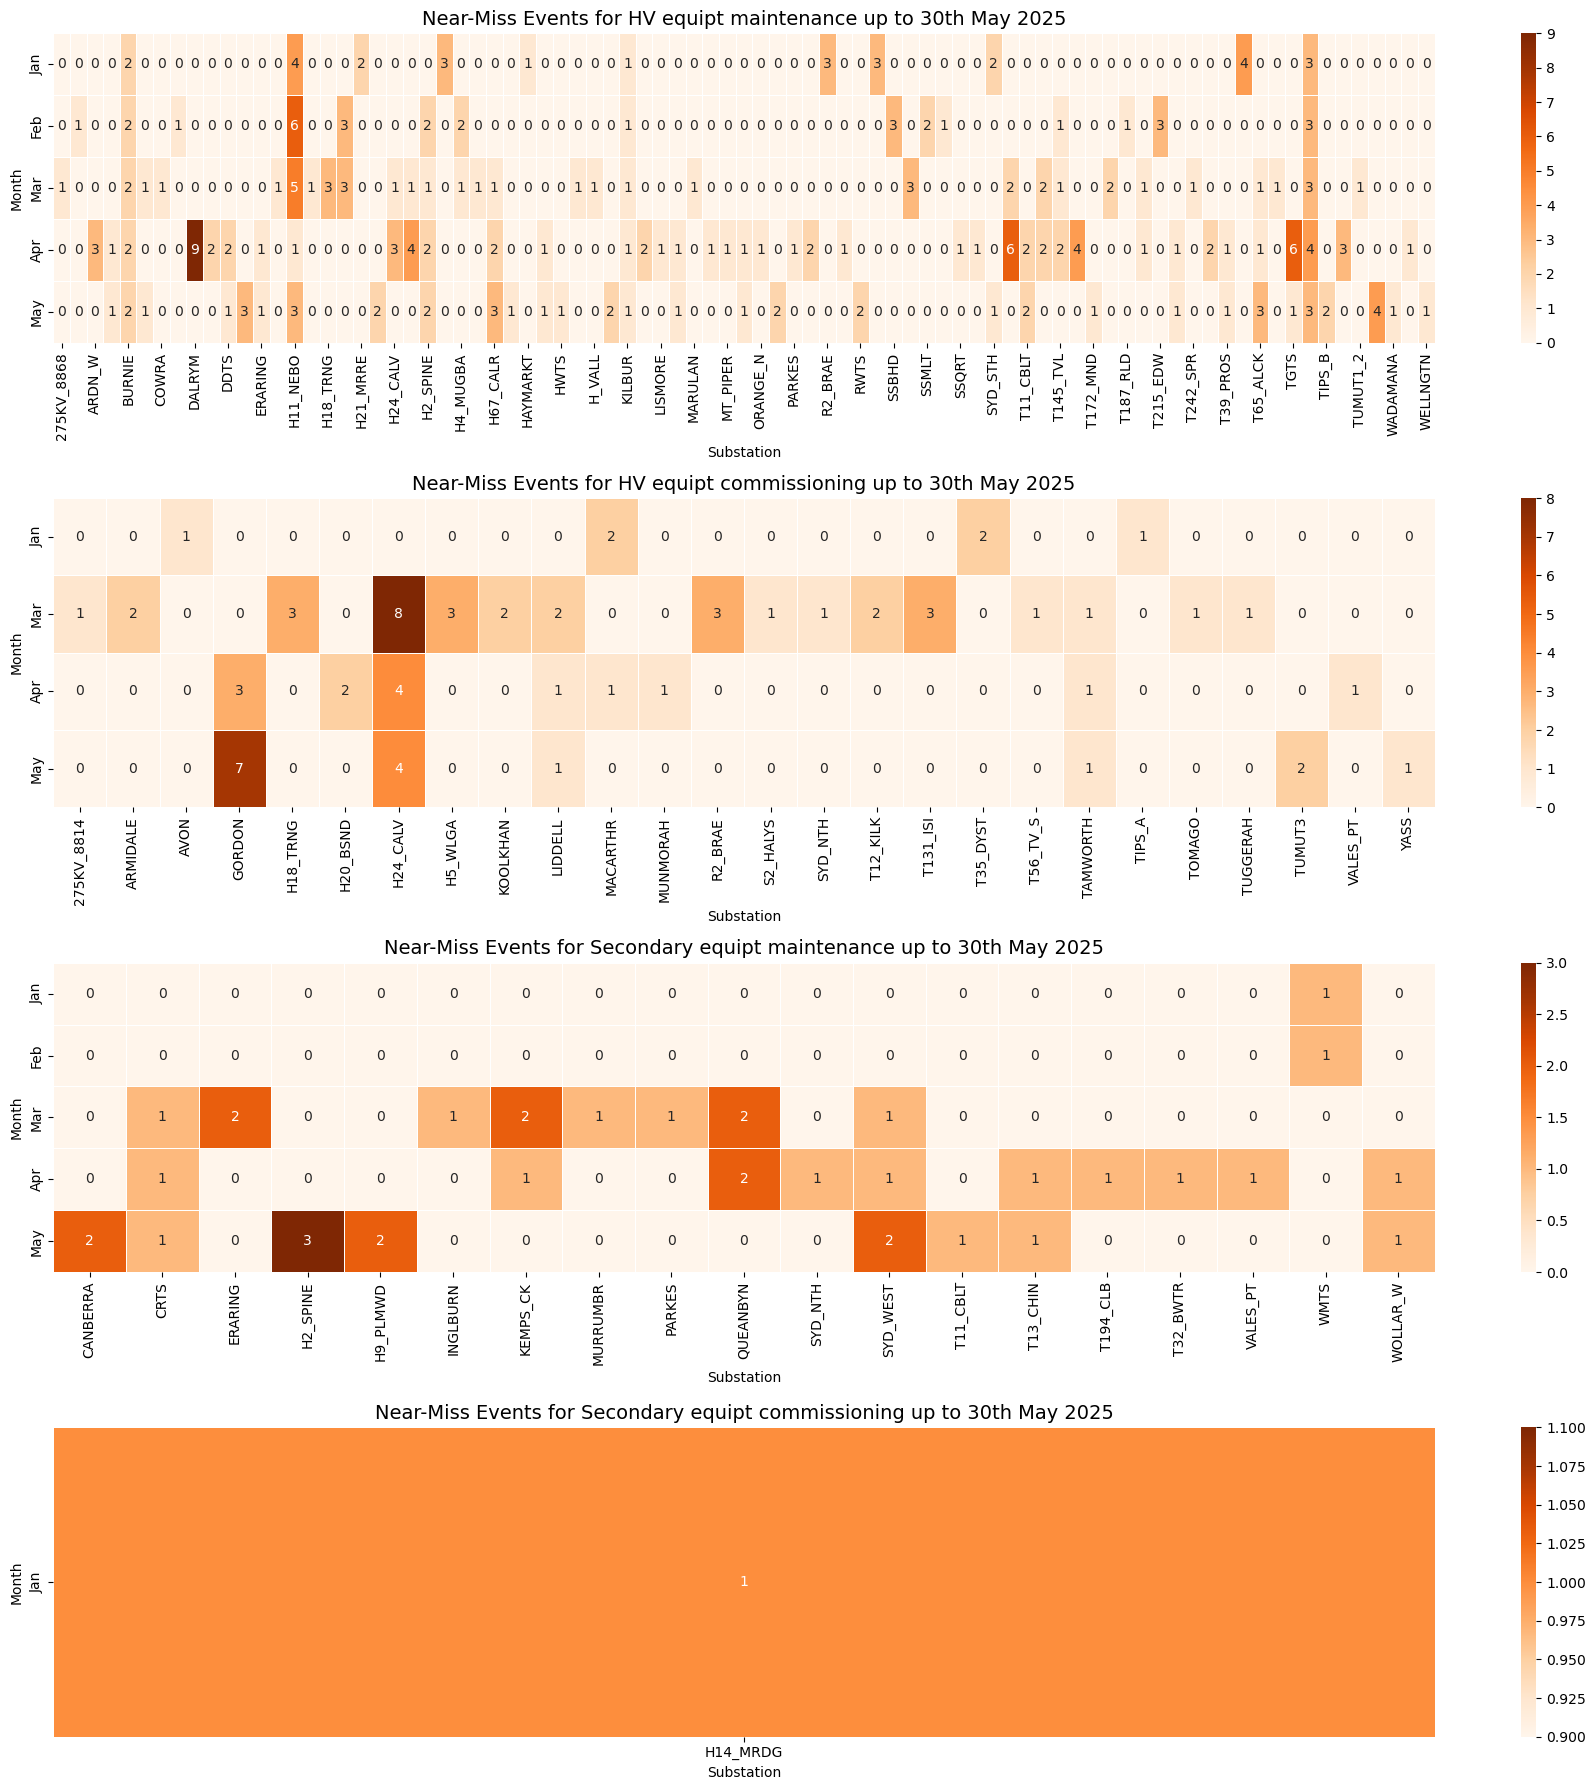

In [26]:
import calendar
import seaborn as sns
import matplotlib.pyplot as plt

cutoff_date = pd.to_datetime("2025-05-30")

df_2025 = near_miss_df[
    (near_miss_df['MONTHLY_ARCHIVE_STARTTIME'] <= cutoff_date) &
    (near_miss_df['MONTHLY_ARCHIVE_STARTTIME'].dt.year == 2025)
].copy()

# Extract MONTH
df_2025['MONTH'] = df_2025['MONTHLY_ARCHIVE_STARTTIME'].dt.month

# Get unique reasons
reasons = df_2025['REASON'].unique()

# Set up the subplots
fig, axs = plt.subplots(nrows=len(reasons), figsize=(18, 4.5 * len(reasons)))  # Bigger plot

# Create a labeled index for months
month_labels = [calendar.month_abbr[m] for m in range(1, 13)]

# Loop through each reason
for i, reason in enumerate(reasons):
    subset = df_2025[df_2025['REASON'] == reason]
    pivot = subset.groupby(['MONTH', 'SUBSTATIONID']).size().unstack(fill_value=0)
    pivot.index = [calendar.month_abbr[m] for m in pivot.index]  # Convert to month names
    
    sns.heatmap(
        pivot, 
        ax=axs[i], 
        cmap='Oranges', 
        annot=True, 
        fmt='d', 
        linewidths=0.5
    )
    axs[i].set_title(f'Near-Miss Events for {reason} up to 30th May 2025', fontsize=14)
    axs[i].set_xlabel('Substation')
    axs[i].set_ylabel('Month')

plt.tight_layout()
plt.show()


<Figure size 1400x600 with 0 Axes>

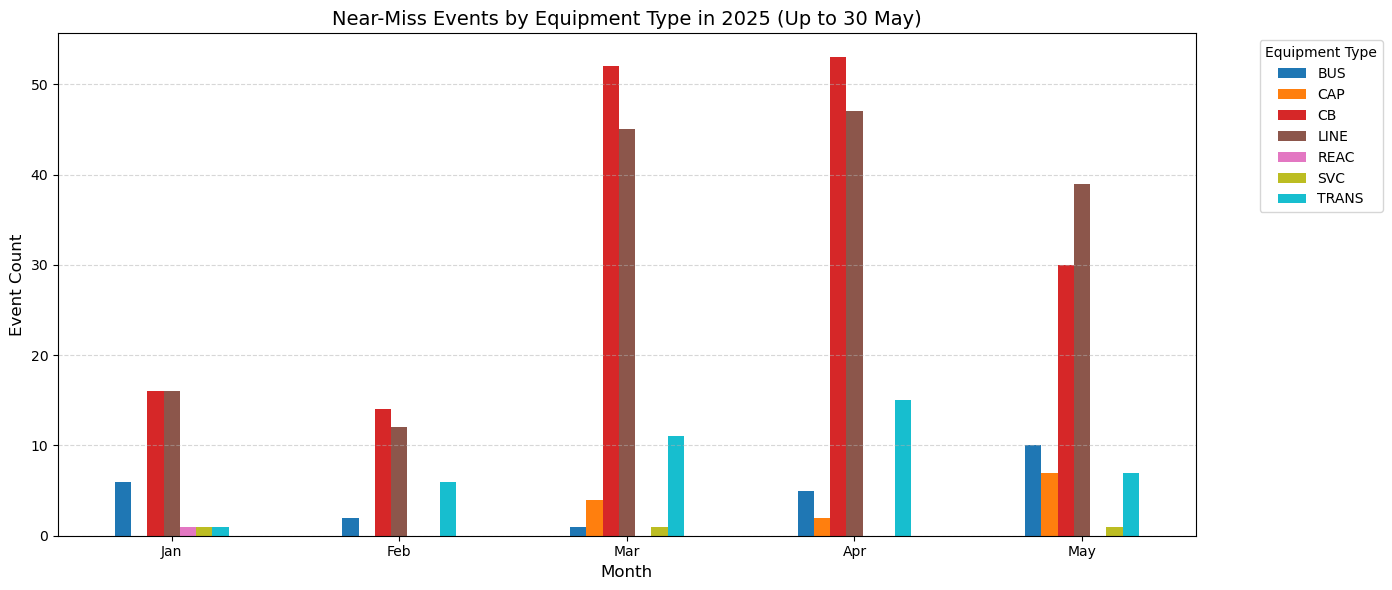

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

# Filter for 2025 and only up to 30 May
cutoff_date = pd.to_datetime("2025-05-30")
df_2025 = near_miss_df[
    (near_miss_df['MONTHLY_ARCHIVE_STARTTIME'] <= cutoff_date) &
    (near_miss_df['MONTHLY_ARCHIVE_STARTTIME'].dt.year == 2025) &
    (near_miss_df['EQUIPMENTTYPE'].notna())
].copy()

# Group by Month and Equipment Type
monthly_equipment = df_2025.groupby(['MONTH', 'EQUIPMENTTYPE']).size().unstack().fillna(0)

# Convert month numbers to abbreviated names
monthly_equipment.index = [calendar.month_abbr[int(m)] for m in monthly_equipment.index]

# Plot grouped bar chart
plt.figure(figsize=(14, 6))
monthly_equipment.plot(kind='bar', figsize=(14, 6), colormap='tab10')

plt.title('Near-Miss Events by Equipment Type in 2025 (Up to 30 May)', fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Event Count", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Equipment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


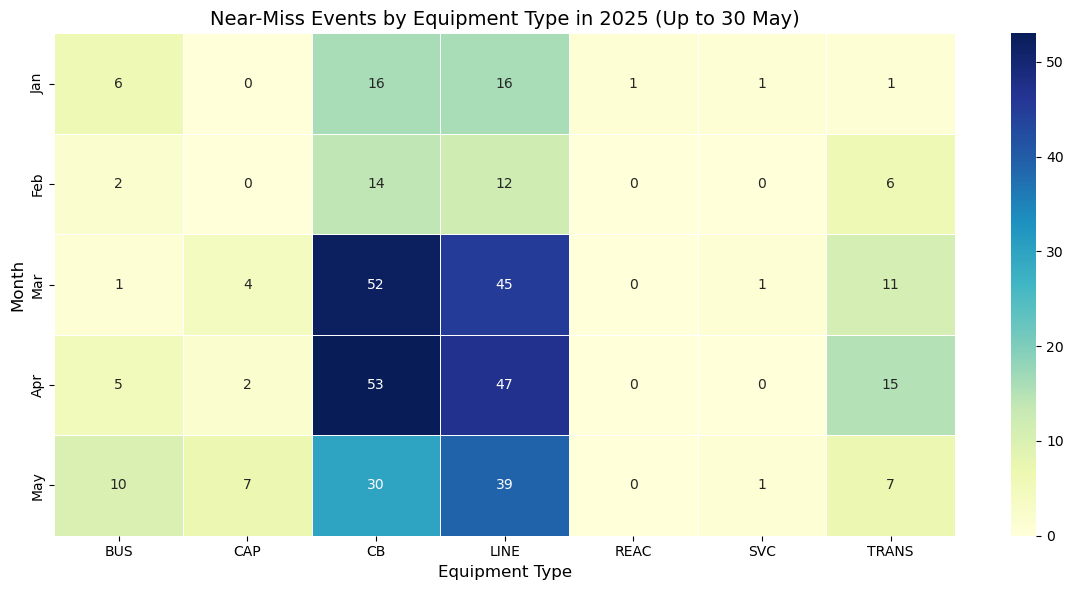

In [28]:


# Filter data for 2025 up to 30 May
cutoff_date = pd.to_datetime("2025-05-30")
df_2025 = near_miss_df[
    (near_miss_df['MONTHLY_ARCHIVE_STARTTIME'] <= cutoff_date) &
    (near_miss_df['MONTHLY_ARCHIVE_STARTTIME'].dt.year == 2025) &
    (near_miss_df['EQUIPMENTTYPE'].notna())
].copy()

# Group by month and equipment type
heatmap_data = df_2025.groupby(['MONTH', 'EQUIPMENTTYPE']).size().unstack().fillna(0)

# Convert month index to abbreviated month names
heatmap_data.index = [calendar.month_abbr[int(m)] for m in heatmap_data.index]

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='YlGnBu', linewidths=0.5)

plt.title('Near-Miss Events by Equipment Type in 2025 (Up to 30 May)', fontsize=14)
plt.xlabel('Equipment Type', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.tight_layout()
plt.show()


## 6) Near-Miss Analysis for 2009–2011 (Historical Spike Period)

To contextualise the 2025 spike, I analysed the last historically significant cluster of near-miss events—between **2009 and 2011**—using a consistent visualisation approach for direct comparison.

### 🔍 Key Steps:
- **Filtered the near-miss dataset** to include only entries from the years **2009, 2010, and 2011**.
- Extracted **monthly and yearly breakdowns**, and grouped data by **substation**, **equipment type**, and **reason** to explore spatial and operational distributions.
- **Created heatmaps** using Seaborn to visualise:
  - Near-miss events by **reason and substation** (monthly granularity).
  - Monthly trends in near-miss **equipment involvement** (e.g., CB, LINE, BUS).
- **Plotted bar charts** and **heatmaps** to compare **equipment trends across months**, mirroring the 2025 analysis.

### 📊 Key Findings:
- Unlike 2025, near-miss events from 2009 to 2011 were more **spread across the year**, without a strong seasonal cluster.
- **Circuit breakers (CB)** and **transmission lines (LINE)** were again the most frequently involved equipment types—showing a **consistent vulnerability pattern**.
- Substations like **T21_J**, **SYD_NTH**, and **T12_D** appeared multiple times, indicating **recurring infrastructure risks** during this period.
- The volume of near-miss events rose from **41 in 2009 to 129 in 2011**—a **216% increase**, forming the last major spike before 2025.

This analysis highlights how **long-standing weaknesses** in certain asset types have persisted across more than a decade. Comparing this with 2025 helps establish **recurring patterns in grid instability**, which are critical for long-term risk mitigation and planning.


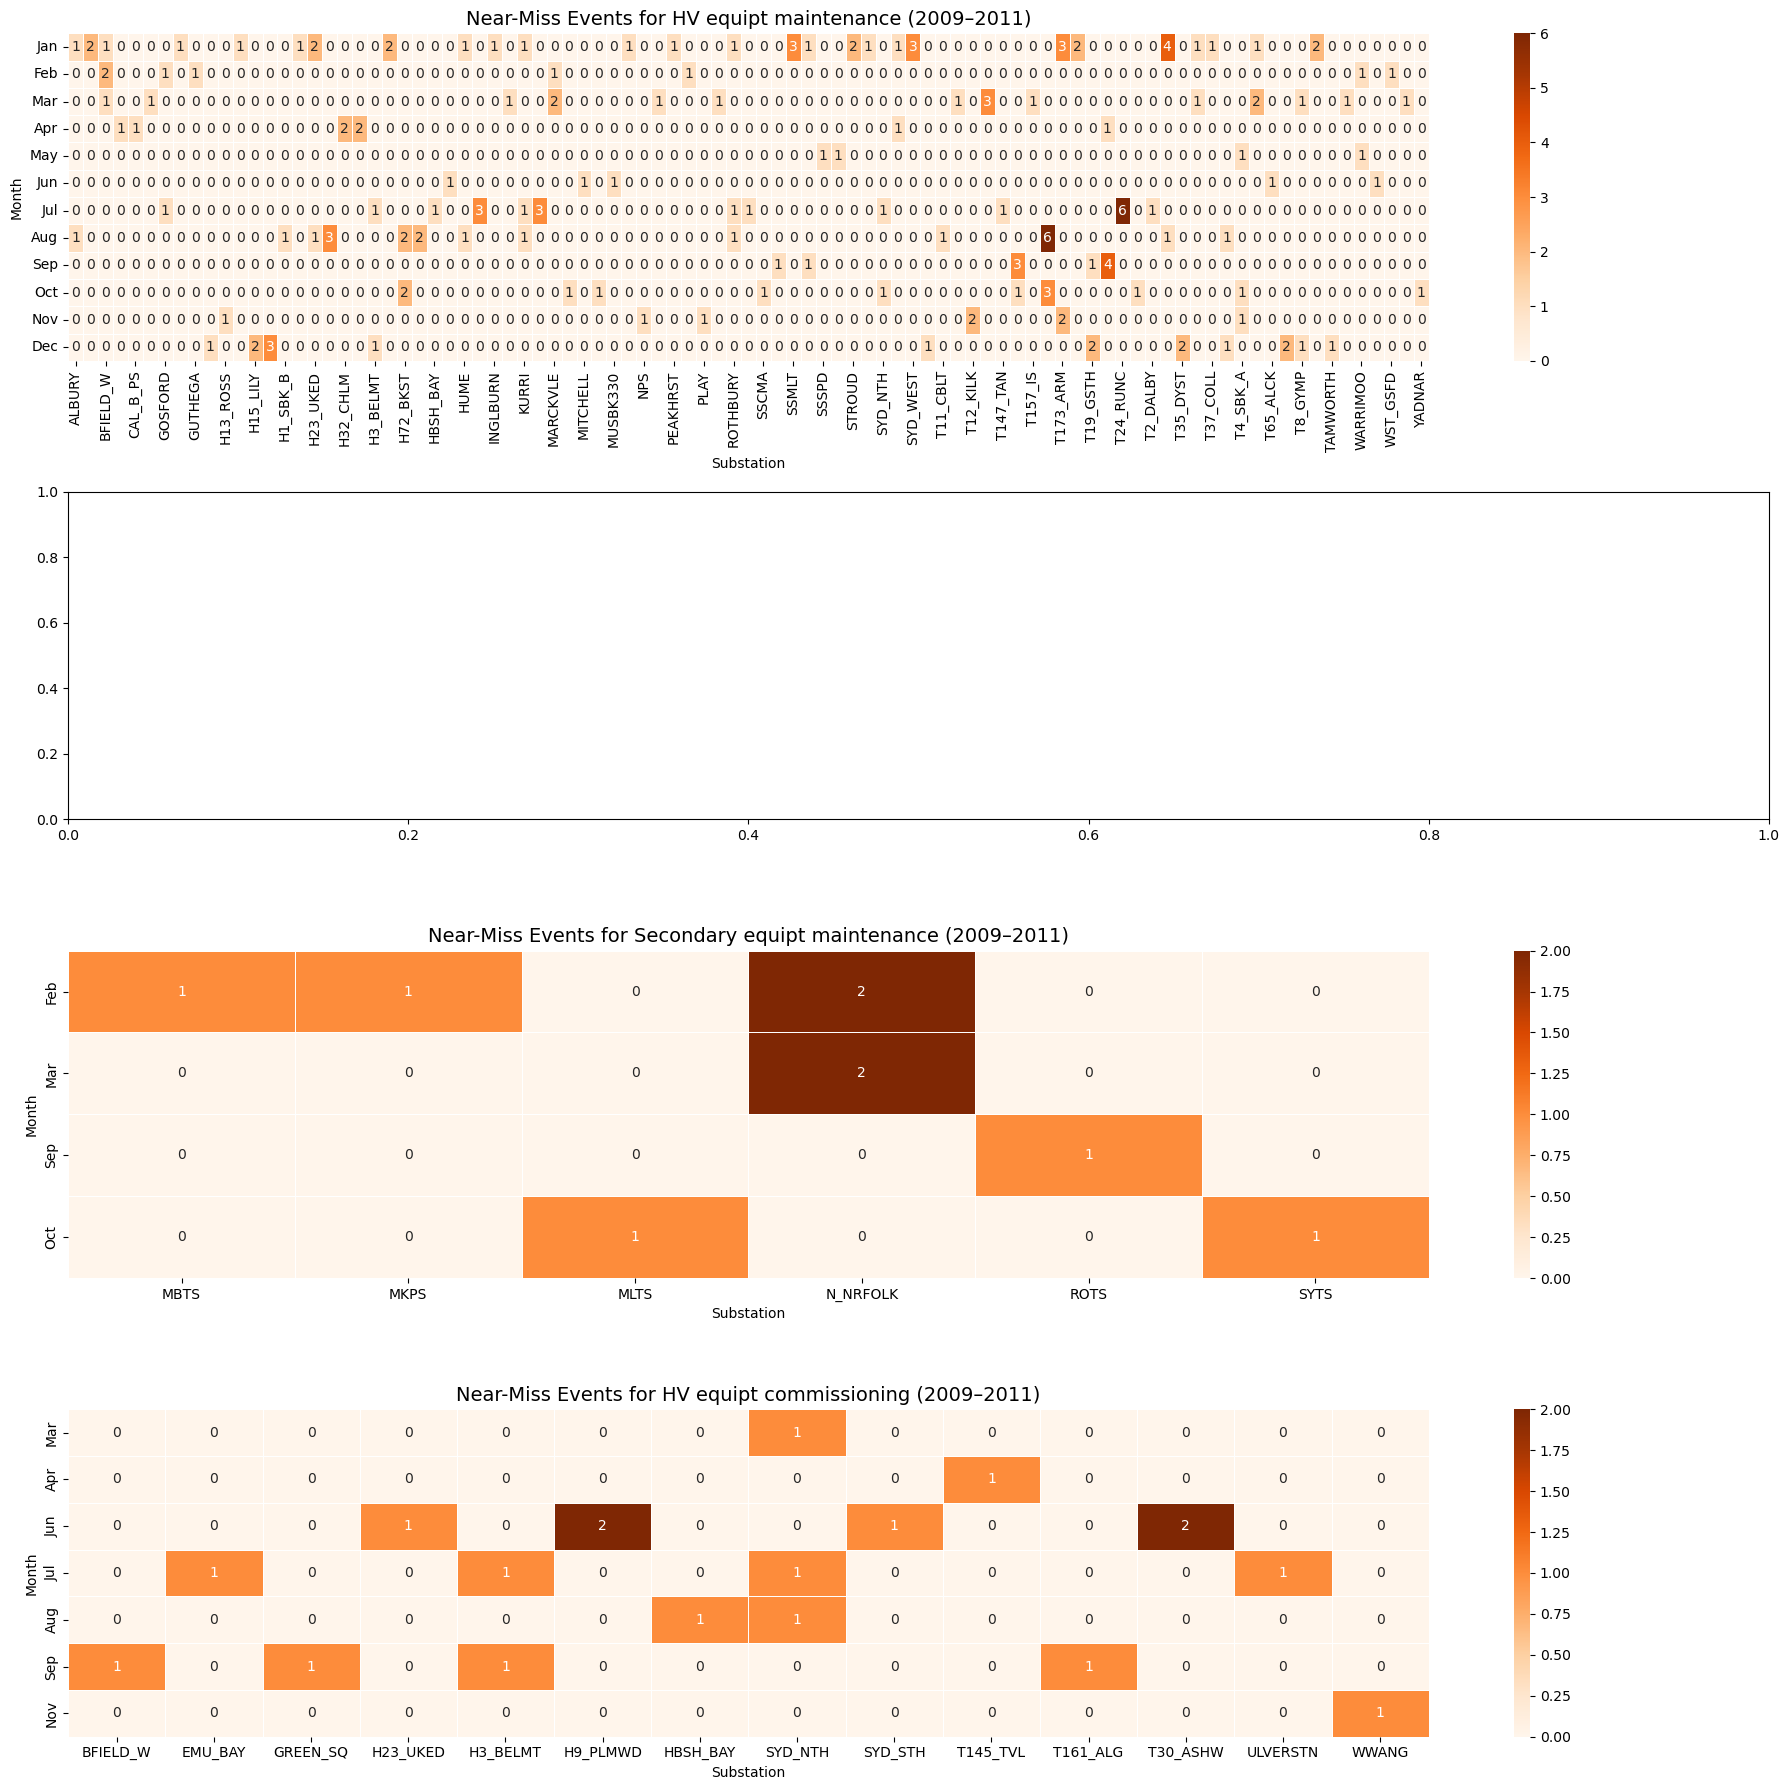

In [29]:
import calendar
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for 2009–2011
df_0911 = near_miss_df[
    (near_miss_df['MONTHLY_ARCHIVE_STARTTIME'].dt.year >= 2009) &
    (near_miss_df['MONTHLY_ARCHIVE_STARTTIME'].dt.year <= 2011)
].copy()

# Extract month column if not already extracted
df_0911['MONTH'] = df_0911['MONTHLY_ARCHIVE_STARTTIME'].dt.month

# Get unique reasons
reasons = df_0911['REASON'].unique()

# Set up the subplots
fig, axs = plt.subplots(nrows=len(reasons), figsize=(18, 4.5 * len(reasons)))

# Create month labels
month_labels = [calendar.month_abbr[m] for m in range(1, 13)]

# Loop through each reason
for i, reason in enumerate(reasons):
    subset = df_0911[df_0911['REASON'] == reason]
    pivot = subset.groupby(['MONTH', 'SUBSTATIONID']).size().unstack(fill_value=0)
    
    # Skip if the pivot is empty
    if pivot.empty:
        continue
    
    pivot.index = [calendar.month_abbr[m] for m in pivot.index]  # Convert month numbers to names
    
    sns.heatmap(
        pivot, ax=axs[i],
        cmap='Oranges', annot=True, fmt='d', linewidths=0.5
    )
    axs[i].set_title(f'Near-Miss Events for {reason} (2009–2011)', fontsize=14)
    axs[i].set_xlabel('Substation')
    axs[i].set_ylabel('Month')

plt.tight_layout()
plt.show()


<Figure size 1400x600 with 0 Axes>

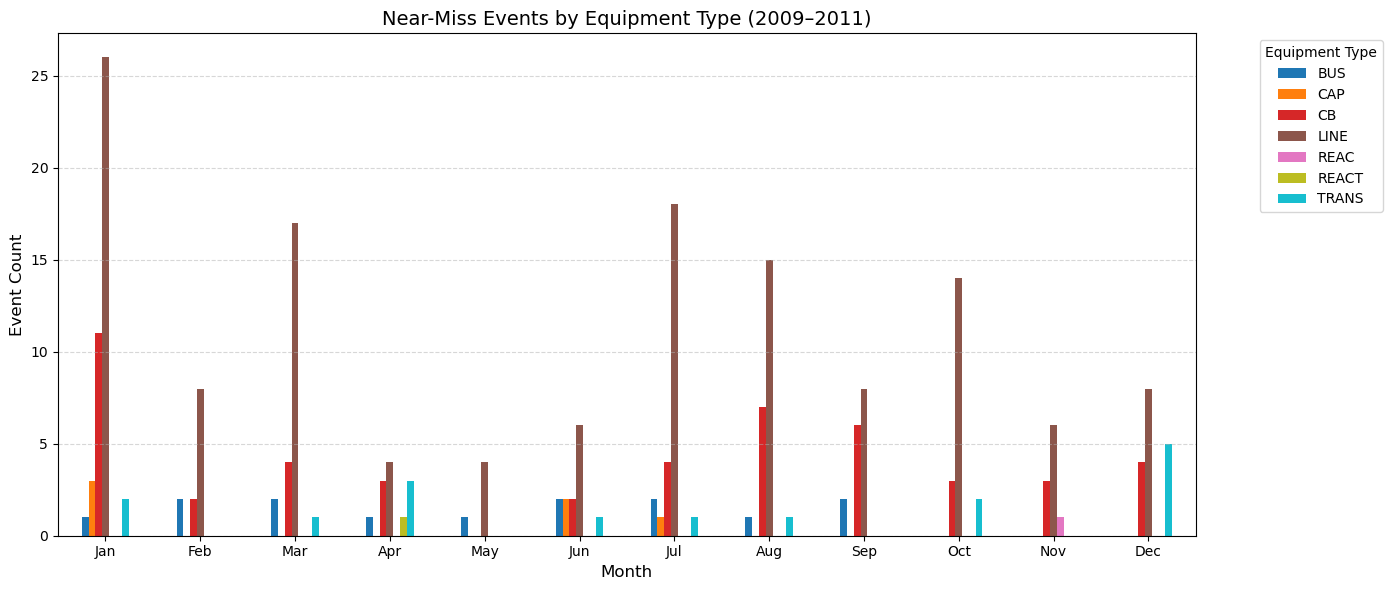

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

# Filter for 2009–2011 and valid equipment entries
df_0911 = near_miss_df[
    (near_miss_df['MONTHLY_ARCHIVE_STARTTIME'].dt.year.isin([2009, 2010, 2011])) &
    (near_miss_df['EQUIPMENTTYPE'].notna())
]

# Group by Month and Equipment Type
monthly_equipment_0911 = df_0911.groupby(['MONTH', 'EQUIPMENTTYPE']).size().unstack().fillna(0)

# Convert month numbers to abbreviated names
monthly_equipment_0911.index = [calendar.month_abbr[int(m)] for m in monthly_equipment_0911.index]

# Plot grouped bar chart
plt.figure(figsize=(14, 6))
monthly_equipment_0911.plot(kind='bar', figsize=(14, 6), colormap='tab10')

plt.title('Near-Miss Events by Equipment Type (2009–2011)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Event Count', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Equipment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


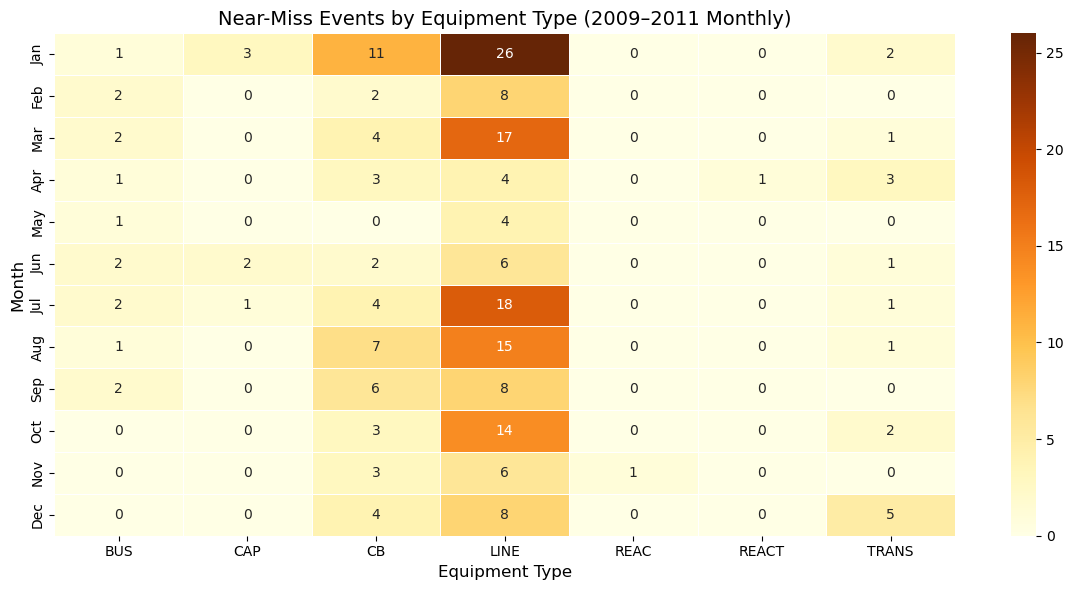

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

# Filter data for 2009 to 2011 and valid equipment entries
df_0911 = near_miss_df[
    (near_miss_df['MONTHLY_ARCHIVE_STARTTIME'].dt.year.isin([2009, 2010, 2011])) &
    (near_miss_df['EQUIPMENTTYPE'].notna())
]

# Group by Month and Equipment Type
heatmap_data_0911 = df_0911.groupby(['MONTH', 'EQUIPMENTTYPE']).size().unstack().fillna(0)

# Convert numeric month index to month abbreviation (Jan, Feb, etc.)
heatmap_data_0911.index = [calendar.month_abbr[int(m)] for m in heatmap_data_0911.index]

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data_0911, annot=True, fmt='g', cmap='YlOrBr', linewidths=0.5)

plt.title('Near-Miss Events by Equipment Type (2009–2011 Monthly)', fontsize=14)
plt.xlabel('Equipment Type', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.tight_layout()
plt.show()
